# HW4: Structure-from-motion

Ref:

- https://blog.csdn.net/haizimin/article/details/49836077
- https://github.com/jesolem/PCV/blob/master/pcv_book/sfm.py
- multiple view geometry in computer vision
http://cvrs.whu.edu.cn/downloads/ebooks/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf

In [41]:
#%matplotlib notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hw3
np.set_printoptions(suppress=True)

## 讀取圖片

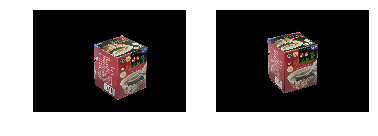

In [42]:
DEBUG_IMAGE_INDEX = 1

if(DEBUG_IMAGE_INDEX==1):
    image1 = cv2.imread('./data/Mesona1.JPG')
    image2 = cv2.imread('./data/Mesona2.JPG')
elif(DEBUG_IMAGE_INDEX == 2):
    image1 = cv2.imread('./data/Statue1.bmp')
    image2 = cv2.imread('./data/Statue2.bmp')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

## 計算相機內部參數

In [43]:
intrinsic_matrix1 = np.zeros((3,3))
intrinsic_matrix1 = np.zeros((3,3))

if(DEBUG_IMAGE_INDEX == 1):
    intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                                  [0, 1.4219, 0.3802],
                                  [0, 0, 0.0010]])
    intrinsic_matrix1 = intrinsic_matrix1 / intrinsic_matrix1[2,2]
    intrinsic_matrix2 = intrinsic_matrix1
else:
    intrinsic_matrix1 = np.array([[5426.566895, 0.678017, 330.096680],
                 [0.000000, 5423.133301, 648.950012],
                 [0.000000, 0.000000, 1.000000]])

    intrinsic_matrix2 = np.array([[5426.566895, 0.678017, 387.430023],
                  [0.000000, 5423.133301, 620.616699],
                  [0.000000, 0.000000, 1.000000]])
print("Intrinsic Matrix 1\n", intrinsic_matrix1)
print("Intrinsic Matrix 2\n", intrinsic_matrix2)

Intrinsic Matrix 1
 [[ 1421.9     5.    509.2]
 [    0.   1421.9   380.2]
 [    0.      0.      1. ]]
Intrinsic Matrix 2
 [[ 1421.9     5.    509.2]
 [    0.   1421.9   380.2]
 [    0.      0.      1. ]]


## 計算特徵點

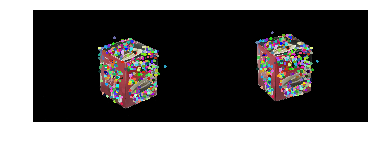

(<matplotlib.image.AxesImage at 0x1bbd8bc1710>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [44]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order, draw_line=False, circle_size=10)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

## Fundamental and Essential Matrix

In [45]:
def get_normalization_matrix(pts):
    '''
        get the normalization matrix
    '''
    x_mean, y_mean = np.mean(pts, axis=0)
    x_var, y_var = np.var(pts, axis=0)    
    x_s, y_s = np.sqrt(2/x_var), np.sqrt(2/y_var)
    n = np.array([[x_s, 0, -x_s*x_mean], 
                  [0, y_s, -y_s*y_mean], 
                  [0, 0, 1]])
    
    return n.astype(np.float64)

def normalization(imgpts1, imgpts2):
    '''
        ref: lecture P.54
    '''
    # t1: image1 normalization matrix, t2: image2 normalization matrix
    t1, t2 = get_normalization_matrix(imgpts1), get_normalization_matrix(imgpts2)
    
    # to homography coordinate
    homopts1 = np.array([ [each[0], each[1], 1.0] for each in imgpts1])
    homopts2 = np.array([ [each[0], each[1], 1.0] for each in imgpts2])
    
    num_of_point = len(imgpts1)
    for i in range(num_of_point): 
        
        #最後一項要為1
        p2h = np.matmul(t1, homopts1[i])
        homopts1[i] = p2h/p2h[-1]
        
        p2h1 = np.matmul(t2, homopts2[i])
        homopts2[i] = p2h1/p2h1[-1]
    
    normalpts1 = np.delete(homopts1, -1, axis=1)
    normalpts2 = np.delete(homopts2, -1, axis=1)
    
    return normalpts1, normalpts2, t1, t2

def denormalize_fundamental_mat(normalmat1, normalmat2, normalize_fundamental):
    '''
        ref: Multiple View Geometry in Computer Vision - Algorithm 11.1
    '''
    transpose_normalmat2 = np.transpose(normalmat2)
    return np.matmul(np.matmul(transpose_normalmat2, normalize_fundamental), normalmat1)

def get_fundamental(samplept1, samplept2):
    '''
        ref: Multiple View Geometry in Computer Vision - Chapter 11.1, lecture P.50
    '''
    # normalization the key points
    normalpts1, normalpts2, nomalmat1, normalmat2 = normalization(samplept1, samplept2)
    
    A = np.zeros((len(normalpts1), 9), dtype=np.float64)
    for i in range(len(normalpts1)):
        x, y = normalpts1[i][0], normalpts1[i][1]
        xi, yi = normalpts2[i][0], normalpts2[i][1]
        A[i] = np.array([xi*x, xi*y, xi, yi*x, yi*y, yi, x, y, 1])
    
    # resolve det(f) = 0
    u, s, v = np.linalg.svd(A)
    F = v[np.argmin(s)]
    F = F.reshape(3, 3)
    u, s, v = np.linalg.svd(F)
    s = np.array([[s[0], 0 ,0],
                 [0, s[1], 0],
                 [0 , 0, 0]])
    F = np.matmul(np.matmul(u, s), v)
    
    # homographs coefficient and denormalize the fundamental matrix
    F = denormalize_fundamental_mat(nomalmat1, normalmat2, F)
    F = F/F[-1,-1]
    
    return F

def get_geometric_error(testpts1, testpts2, fundamentalmat, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.4.3
    '''
    error = 0
    inliner_number = 0
    inlinerpts1, inlinerpts2 = np.zeros(testpts1.shape), np.zeros(testpts1.shape)
    for i in range(len(testpts1)):
        
        # transform test points to homography coordinate
        x = np.array([testpts1[i][0], testpts1[i][1], 1])
        xi = np.array([testpts2[i][0], testpts2[i][1], 1])
        
        fx = np.matmul(fundamentalmat, x)
        ftx = np.matmul(np.transpose(fundamentalmat), xi)
        
        m = np.power(np.matmul(np.matmul(np.transpose(xi), fundamentalmat), x), 2)
        d = np.power(fx[0], 2) + np.power(fx[1], 2) + np.power(ftx[0], 2) + np.power(ftx[1], 2)
        
        distance = m/d
        error += distance
        if(distance < inliner_threshold):
            inlinerpts1[inliner_number], inlinerpts2[inliner_number] = testpts1[i], testpts2[i]
            inliner_number += 1
            
    return error, inliner_number, inlinerpts1[:inliner_number, :], inlinerpts2[:inliner_number, :]

def get_essential_mat(K1, K2, F):
    '''
        ref: Multiple View Geometry 9.12
    '''
    if(K1[-1,-1] != 1):
        K1 = K1 / K1[-1,-1]
    if(K2[-1,-1] != 1):
        K2 = K2 / K2[-1,-1]
        
    E = np.dot( K2.T , np.dot(F,K1))
    
    return E
def find_fundamental_by_RANSAC(matchedpt_order, imgpts1, imgpts2, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.6
    '''
    print("Key Point Number\n", len(imgpts1))
    ransac_iteration = 500
    ransac_sample_number = 32
    
    best_error = 0
    best_fundamental = np.zeros((3,3))
    best_inlinernum = 0
    best_inlinerpts1, best_inlinerpts2 = np.zeros((2,1))
    for i in range(ransac_iteration):
        sampts1, sampts2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
        f = get_fundamental(sampts1, sampts2)
        error, inlinernum, inlinerpts1, inlinerpts2 = get_geometric_error(imgpts1, imgpts2, f, inliner_threshold)
        if(inlinernum > best_inlinernum):
            best_error = error
            best_fundamental = f
            best_inlinernum = inlinernum
            best_inlinerpts1, best_inlinerpts2 = inlinerpts1, inlinerpts2
    best_essential = get_essential_mat(intrinsic_matrix1, intrinsic_matrix2, best_fundamental)
    print("RANSC Error\n", best_error)
    print("Inliner Number\n", best_inlinernum)
    return best_fundamental, best_essential, best_inlinerpts1, best_inlinerpts2 

RANSAC_INLINER_THRESHOLD = 0.25

# find the fundamnetal matrix
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
print('keypts1.shape\n', imgpts1.shape)
# import answer
# imgpts1, imgpts2, _= answer.sift_detector(image1, image2)
# imgpts1 = np.float64(imgpts1)
# imgpts2 = np.float64(imgpts2)
fundamentalmat, essentialmat, inlinerpts1, inlinerpts2 = find_fundamental_by_RANSAC(matched_pt_order, imgpts1, imgpts2, RANSAC_INLINER_THRESHOLD)
print("F\n", fundamentalmat)
print("E\n", essentialmat)
print('inlinerpts1.sahpe\n', inlinerpts1.shape)
print('inlinerpts2.sahpe\n', inlinerpts2.shape)

# by opencv
#fundamentalmat_opencv, _ = cv2.findFundamentalMat(imgpts1, imgpts2, cv2.RANSAC, RANSAC_INLINER_THRESHOLD, 0.99, None)
fundamentalmat_opencv, _= cv2.findFundamentalMat(imgpts1, imgpts2, method =cv2.FM_8POINT + cv2.FM_RANSAC)
essentialmat_opencv = get_essential_mat(intrinsic_matrix1, intrinsic_matrix2, fundamentalmat_opencv)
cv_error, cv_inlinernum, _, _ = get_geometric_error(imgpts1, imgpts2, fundamentalmat_opencv, RANSAC_INLINER_THRESHOLD)
print("CV RANSC Error\n", cv_error)
print("CV Inliner Number\n", cv_inlinernum)
print("F by opencv\n", fundamentalmat_opencv)
print("E by opencv\n", essentialmat_opencv)

keypts1.shape
 (595, 2)
Key Point Number
 595
RANSC Error
 464894.892066
Inliner Number
 354
F
 [[-0.00000004 -0.00000217 -0.00110663]
 [ 0.00000109 -0.00000025  0.01833212]
 [ 0.00025822 -0.01714751  1.        ]]
E
 [[ -0.08213538  -4.39751501  -2.77869832]
 [  2.21033018  -0.50387395  26.7156462 ]
 [  0.92884933 -26.08615348   0.76299269]]
inlinerpts1.sahpe
 (354, 2)
inlinerpts2.sahpe
 (354, 2)
CV RANSC Error
 469838.736422
CV Inliner Number
 205
F by opencv
 [[ 0.00000085  0.00001079 -0.00566836]
 [-0.00001176  0.00000077  0.02057989]
 [ 0.0035924  -0.01913668  1.        ]]
E by opencv
 [[  1.71602197  21.82061742  -1.6123409 ]
 [-23.76041913   1.54885652  21.16178468]
 [ -0.63231573 -18.9846151    0.63602578]]


## Draw Epipolar Lines

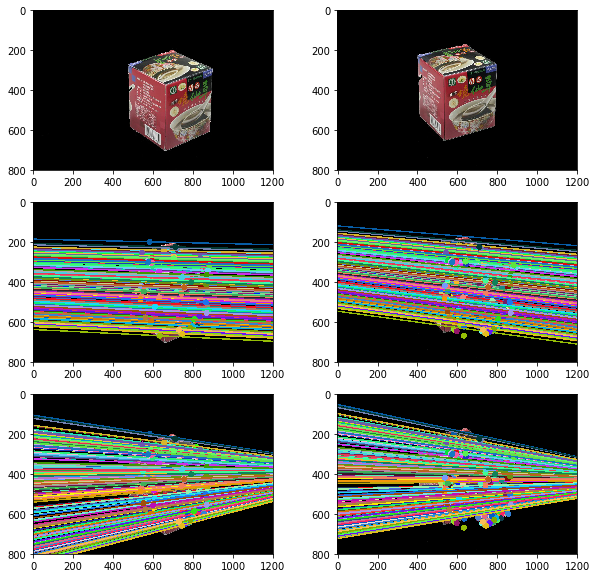

In [46]:
def compute_correspond_epilines(keypts, which_image, fundamental):
    '''
        ref: https://github.com/opencv/opencv/blob/f5801ee7dac4114ac2995a5fd3866ac7775752f7/modules/calib3d/src/fundam.cpp#L836
        l = Fx'
        l' = F^Tx
    '''
    lines = np.zeros((len(keypts), 3))
    
    if (which_image == 2):
        fundamental = np.transpose(fundamental)
    
    for i, p in enumerate(keypts):
        hp = np.array([p[0], p[1], 1])
        l = np.matmul(fundamental, np.transpose(hp))
        
        a, b, c = l[0], l[1], l[2]
        check = a*a + b*b
        if check != 0:
            check = np.sqrt(check)
        else:
            check = 1
        lines[i] = np.array([a/check, b/check ,c/check])
        
    return lines

def draw_epilines(img1, img2, lines, pts1, pts2, colors):
    '''
        ref: https://docs.opencv.org/3.4.4/da/de9/tutorial_py_epipolar_geometry.html
        x0, y0 = (0, -b/c)
        x1, y1 = (w, -(aw+c)/b)
    '''
    imgA = np.copy(img1)
    imgB = np.copy(img2)
    h, w, _ = img1.shape
    
    i=0
    for r,pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = (0, int(-r[2]/r[1]))
        x1, y1 = (w, int(-(r[0]*w+r[2])/r[1]))
        imgA = cv2.line(imgA, (x0, y0), (x1, y1), colors[i], 5)
        imgA = cv2.circle(imgA, (int(pt1[0]), int(pt1[1])), 15, colors[i], -1)
        imgB = cv2.circle(imgB, (int(pt2[0]), int(pt2[1])), 15, colors[i], -1)
        i += 1
    return imgA, imgB

colors = np.zeros((len(inlinerpts1), 3))
for i in range(len(inlinerpts1)):
    colors[i] = tuple(np.random.randint(0, 255, 3).tolist())

# show image epilines
lines1 = compute_correspond_epilines(inlinerpts2, 2, fundamentalmat)
img3, _ = draw_epilines(image1, image2, lines1, inlinerpts1, inlinerpts2, colors)
lines2 = compute_correspond_epilines(inlinerpts1, 1, fundamentalmat)
img4, _ = draw_epilines(image2, image1, lines2, inlinerpts1, inlinerpts2, colors)

# by opencv
lines3 = cv2.computeCorrespondEpilines(inlinerpts2, 2, fundamentalmat_opencv)
lines3 = lines3.reshape(-1,3)
img5, _ = draw_epilines(image1, image2, lines3, inlinerpts1, inlinerpts2, colors)
lines4 = cv2.computeCorrespondEpilines(inlinerpts1, 1, fundamentalmat_opencv)
lines4 = lines4.reshape(-1,3)
img6, _ = draw_epilines(image2, image1, lines4, inlinerpts1, inlinerpts2, colors)

plt.figure(figsize=(10, 10))
plt.subplot(321), plt.imshow(image1)
plt.subplot(322), plt.imshow(image2)
plt.subplot(323), plt.imshow(img3)
plt.subplot(324), plt.imshow(img4)
plt.subplot(325),plt.imshow(img5)
plt.subplot(326),plt.imshow(img6)
plt.show()

## Projection Matrix
project matirx = K[R|t] = 3x4

camera matrix = intrinsic matrix = k = 3x3

external rotation matrix = R = 3x3

translation matrix = t = 1x3

In [47]:
# first camera matrix (ref: Multiple View Geometry 9.19)
def check_coherent_rotatio(rotation):
    '''
        We can install a check to see if the
        rotation element is a valid rotation matrix. Keeping in mind that rotation matrices must have a
        determinant of 1 (or -1)
    '''
    if((abs(np.linalg.det(rotation)) - 1.0) > 1e-03):
        print('This is not a valid rotation matrix')
    return True

def get_camera_matrix(e, k1, k2):
    
    def combine_external(r, t):
        ex = np.array([[r[0,0], r[0,1], r[0,2], t[0]],
                      [r[1,0], r[1,1], r[1,2], t[1]],
                      [r[2,0], r[2,1], r[2,2], t[2]],])
        return ex
    
    # camera 1 project matrix
    I = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    p1 = np.matmul(k1, combine_external(I, [0, 0, 0]))

    # skew-symmetric (ref: Multiple View Geometry 9.13)
    W = np.array([[0, -1, 0], 
                  [1, 0, 0], 
                  [0, 0, 1]])
    U, S, Vt = np.linalg.svd(e)
    
    R1 = np.matmul(np.matmul(U, W), Vt)
    R2 = np.matmul(np.matmul(U, W.T), Vt)
    t= U[:,-1].reshape(3,1)

    # Thre have four camera direction (ref: Multiple View Geometry 9.14)
    ps2 = np.zeros((4, 3, 4))
    ps2[0] = np.matmul(k2, combine_external(R1, t))
    ps2[1] = np.matmul(k2, combine_external(R2, t))
    ps2[2] = np.matmul(k2, combine_external(R1, -t))
    ps2[3] = np.matmul(k2, combine_external(R2, -t))
    
    return p1, ps2
p1, ps2 = get_camera_matrix(essentialmat, intrinsic_matrix1, intrinsic_matrix2)
print('p1\n', p1)
print('ps2[0]\n', ps2[0])
print('ps2[1]\n', ps2[1])
print('ps2[2]\n', ps2[2])
print('ps2[3]\n', ps2[3])

p1
 [[ 1421.9     5.    509.2     0. ]
 [    0.   1421.9   380.2     0. ]
 [    0.      0.      1.      0. ]]
ps2[0]
 [[ 1369.02929828   -94.17096576   630.8723006   1308.977816  ]
 [   71.9983826   1421.69011516   374.11909783    88.14250297]
 [   -0.08646351     0.00965379     0.99620824    -0.1672859 ]]
ps2[1]
 [[ 1238.71806562   180.76220952  -844.99220559  1308.977816  ]
 [  103.59923025 -1415.85932959  -388.53726758    88.14250297]
 [   -0.24680369    -0.02072006    -0.96884396    -0.1672859 ]]
ps2[2]
 [[ 1369.02929828   -94.17096576   630.8723006  -1308.977816  ]
 [   71.9983826   1421.69011516   374.11909783   -88.14250297]
 [   -0.08646351     0.00965379     0.99620824     0.1672859 ]]
ps2[3]
 [[ 1238.71806562   180.76220952  -844.99220559 -1308.977816  ]
 [  103.59923025 -1415.85932959  -388.53726758   -88.14250297]
 [   -0.24680369    -0.02072006    -0.96884396     0.1672859 ]]


## Iterative Linear Triangulation

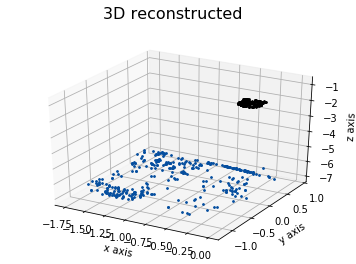

354


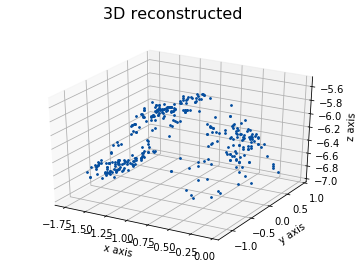

In [48]:
def linear_LS_Triangulation(x1, p1, x2, p2):
    '''
        ref: 1995 Triangulation, ch5.1 Linear Triangulation
        https://perception.inrialpes.fr/Publications/1997/HS97/HartleySturm-cviu97.pdf
    '''
    A = np.array([x1[0]*p1[2,:]-p1[0,:], 
                  x1[1]*p1[2,:]-p1[1,:],
                  x2[0]*p2[2,:]-p2[0,:],
                  x2[1]*p2[2,:]-p2[1,:]])
    
    U, S, V = np.linalg.svd(A)
    X = V[-1]/V[-1,3]
    return X

def in_front_of_camera(R,T,pts,OpenCV=False):
    NumOfPoints = 0
    Camera_Center = -np.dot(np.transpose(R),T)
    View_Directopm = np.transpose(R)[2,:]
    for i in range(pts.shape[1]):
        if OpenCV:
            hp = pts[:,i]
            hp = hp/hp[-1]
            X_Camera_Center = hp[:3] - Camera_Center
        else: 
            X_Camera_Center = pts[i] - Camera_Center
        if np.dot(X_Camera_Center,View_Directopm) > 0 :
            NumOfPoints = NumOfPoints + 1
    return NumOfPoints
  
def triangulate_points(e, x1, x2, p1, ps2):
    
    # get external parameter
    def get_external(e):
        w = np.array([[0.0, -1.0, 0.0],
                     [1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0]])
        z = np.array([[0.0, 1.0, 0.0],
                     [-1.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0]])
        U, S, V = np.linalg.svd(e)
        m = (S[0] + S[1])/2
        S[0] = m
        S[1] = m
        S[2] = 0

        t = np.matmul(np.matmul(U, z), U.T)
        t = np.array([-t[1,2], t[0,2], -t[0,1]])

        R1 = np.matmul(np.matmul(U, w.T), V)
        R2 = np.matmul(np.matmul(U, w), V)

        if(np.linalg.det(R1)==-1.0):
            R1 = -1*R1
            R2 = -1*R2
        return t, R1, R2
    
    T, R1, R2 = get_external(e)
    max_front_count = 0
    correct_ps2_index = -1
    triangulation_points = np.zeros((x1.shape[0], 3))
    for ps2_index, p2 in enumerate(ps2):
        front_count = 0
        project_points = np.zeros((x1.shape[0], 3))
        for i in range(x1.shape[0]):
            x = linear_LS_Triangulation(x1[i], p1, x2[i], p2)
            z_pos = np.matmul(x[0:3], R1[-1,:])
            project_points[i] = x[0:3]
            if(z_pos>0):
                front_count += 1
        #front_count = in_front_of_camera(T, R1, project_points)
        if(front_count > max_front_count):
            max_front_count = front_count
            triangulation_points = np.copy(project_points)
            correct_ps2_index = ps2_index
        
    return triangulation_points, ps2[correct_ps2_index]

def show_cloud_points(pts, cv_pts=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle('3D reconstructed', fontsize=16)
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    for i, p in enumerate(pts):
        xs = p[0]
        ys = p[1]
        zs = p[2]
        ax.scatter(xs, ys, zs, color='#054E9F', s=3)
        
    if(cv_pts is not None):
        for i in range(cv_pts.shape[1]):
            hp = cv_pts[:,i] 
            x = hp[0]
            y = hp[1]
            z = hp[2]
            ax.scatter(x, y, z, color='#000000', s=3)
    plt.show()

def get_cv_projectpts(pts):
    projectpts = np.transpose(pts)
    return projectpts
    
cloudpts, p2 = triangulate_points(essentialmat, inlinerpts1, inlinerpts2, p1, ps2)
cv_inlinerpts1 = get_cv_projectpts(inlinerpts1)
cv_inlinerpts2 = get_cv_projectpts(inlinerpts2)
cloudpts1_cv = cv2.triangulatePoints(p1, p2, cv_inlinerpts1, cv_inlinerpts2)

show_cloud_points(cloudpts, cloudpts1_cv)

import answer
X = answer.cal_P (essentialmat, inlinerpts1, inlinerpts2, intrinsic_matrix1, intrinsic_matrix2)
show_cloud_points(X)

## 測試第二圖

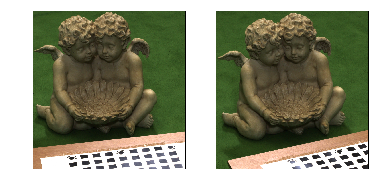

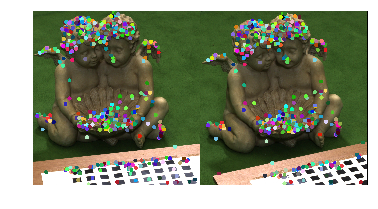

projection matrix 3
 (array([[ 0.140626,  0.989027, -0.045273,  0.      ],
       [ 0.475766, -0.107607, -0.872965,  0.      ],
       [-0.868258,  0.101223, -0.485678,  0.      ]]), array([[[ -7.09955413, -11.03093194,  77.68964571,  78.73525213],
        [ -7.09955413, -11.03093194,  77.68964571,  78.73525213],
        [ -7.09955413, -11.03093194,  77.68964571,  78.73525213]],

       [[ -2.39185723,  -7.64501038,  78.38111389,  78.73525213],
        [ -2.39185723,  -7.64501038,  78.38111389,  78.73525213],
        [ -2.39185723,  -7.64501038,  78.38111389,  78.73525213]],

       [[ -7.09955413, -11.03093194,  77.68964571, -78.73525213],
        [ -7.09955413, -11.03093194,  77.68964571, -78.73525213],
        [ -7.09955413, -11.03093194,  77.68964571, -78.73525213]],

       [[ -2.39185723,  -7.64501038,  78.38111389, -78.73525213],
        [ -2.39185723,  -7.64501038,  78.38111389, -78.73525213],
        [ -2.39185723,  -7.64501038,  78.38111389, -78.73525213]]]))
projection matri

TypeError: tuple indices must be integers or slices, not tuple

In [49]:
def triangulate_points_givenRT(x1, x2, p1, p2):
    project_points = np.zeros((x1.shape[0], 3))
    front_count = 0
    for i in range(x1.shape[0]):
        x = linear_LS_Triangulation(x1[i], p1, x2[i], p2)
        z_pos = np.matmul(x[0:3], R1[-1,:])
        project_points[i] = x[0:3]
        if(z_pos>0):
            front_count += 1
    return project_points, front_countt_count

image3 = cv2.imread('./data/Statue1.bmp')
image4 = cv2.imread('./data/Statue2.bmp')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image3), plt.axis('off')
plt.subplot(122), plt.imshow(image4), plt.axis('off')
plt.show()

# get feature points
sift2 = cv2.xfeatures2d.SIFT_create()
(keypt3, desc3) = sift2.detectAndCompute(image3, None)
(keypt4, desc4) = sift2.detectAndCompute(image4, None)
BF_MACTHER_DISTANCE = 0.65
matches2 = hw3.brute_force_matcher(desc3, desc4, BF_MACTHER_DISTANCE)
matched_pt_order2 = hw3.sort_matched_points(matches2)
matched_feature_image = hw3.show_matched_image(image3, image4, keypt3, keypt4, matched_pt_order2, draw_line=False, circle_size=10)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()
imgpts3, imgpts4 = hw3.get_matched_points(matched_pt_order2, keypt3, keypt4)

k3 = np.array([[5426.566895, 0.678017, 330.096680],
             [0.000000, 5423.133301, 648.950012],
             [0.000000, 0.000000, 1.000000]])
r3 = np.array([[0.140626, 0.989027, -0.045273],
              [0.475766, -0.107607, -0.872965],
              [-0.868258, 0.101223, -0.485678]])
t3 = np.array([67.479439, -6.020049, 40.224911])
projectmat3 = get_camera_matrix(k3, r3, -np.matmul(r3, t3))
print("projection matrix 3\n", projectmat3)

k4 = np.array([[5426.566895, 0.678017, 387.430023],
              [0.000000, 5423.133301, 620.616699],
              [0.000000, 0.000000, 1.000000]])
r4 = np.array([[0.336455, 0.940689, -0.043627],
              [0.446741, -0.200225, -0.871970],
              [-0.828988, 0.273889, -0.487611]])
t4 = np.array([62.882744, -21.081516, 40.544052])
projectmat4 = get_camera_matrix(k4, r4, -np.matmul(r4, t4))
print("projection matrix 3\n", projectmat4)

cloudpts, front_number = triangulate_points_givenRT(imgpts3, imgpts4, projectmat3, projectmat4)
show_cloud_points(cloudpts)
print('front number\n', front_number)